In [1]:
import os
import sys
import json
from scipy import *
import numpy as np
import pandas as pd

%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

import pymc3 as pm
from pymc3 import floatX
import theano
import theano.tensor as tt
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

import seaborn as sn
import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score
)

from sklearn.metrics import (
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)

filterwarnings('ignore')
sns.set_style('white')

set_tt_rng(MRG_RandomStreams(42))
from matplotlib import rcParams
rcParams['axes.titlepad'] = 10 


import time
from datetime import datetime
import calendar

/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [28]:
def d_t_split(df):

    delta_ist__soll_an_nach = df['ist_an_nach1']-df['soll_an_nach'] # scheduled delay in leaving  
    delta_ist__soll_an_von = df['ist_an_von']-df['soll_an_von'] #scheduled delay in arriving
    delta_ist__soll_ab_nach = df['ist_ab_nach']-df['soll_ab_nach'] # Actual Delay in leaving
    delta_ist__soll_ab_von = df['ist_ab_von']-df['soll_ab_von'] #Actual Delay in arriving
    df['total_volume'] = np.ones(df.shape[0])
    df['avg_arrrival_delay_seconds'] = 0.5*(delta_ist__soll_an_von+delta_ist__soll_ab_von)
    df['avg_departure_delay_seconds'] = 0.5*(delta_ist__soll_an_nach+delta_ist__soll_ab_nach)
    t = pd.Series(time.strftime('%H:%M:%S', time.gmtime(x)) for x in dailydata['ist_an_von'])
    df['datetime'] = pd.to_datetime(df['betriebsdatum']+t,format= "%d.%m.%y%H:%M:%S")
    
    '''ad = []
    dd = []


    for i in df.arrrival_delay_seconds:
        if i >=0:
            ad.append(1)
        else:
            ad.append(0)
        
    for i in df.departure_delay_seconds:
        if i >=0:
            dd.append(1)
        else:
            dd.append(0)
    
    df['arrival_delay'] = ad
    df['departure_delay'] = dd'''
    
    dff = df[['datetime','avg_arrrival_delay_seconds','avg_arrrival_delay_seconds','total_volume']]
    dff = dff.groupby("datetime").agg({"avg_arrrival_delay_seconds":"mean"
                                        ,"avg_departure_delay_seconds":"mean"
                                        ,"total_volume":"count"})
    
    
    
    return dff

In [30]:
dailydata = pd.read_csv('fahrzeitensollist2016091120160917.csv')


In [31]:
hs = pd.read_csv("archive/haltestelle.csv")
hp = pd.read_csv("archive/haltepunkt.csv")

In [32]:
haltstelle = hs['halt_lang'].values


In [33]:
klus_find_list_inhs = np.array([i.find('Klusplatz') for i in haltstelle])

In [34]:
oerl_find_list_inhs = np.array([i.find('Oerlikon') for i in haltstelle])

In [35]:
haltstelle[klus_find_list_inhs > -1]

array(['Zürich, Klusplatz'], dtype=object)

In [37]:
print('From      To')
for x in haltstelle[oerl_find_list_inhs > -1]:
    
    print(x)

From      To
Zürich, Sternen Oerlikon
Zürich, Bahnhof Oerlikon
Zürich, Bahnhof Oerlikon Nord
Zürich, Bahnhof Oerlikon Ost
Zürich, Depot 8 Oerlikon
Zürich, Hallenbad Oerlikon


In [22]:
dailydata_Bus = dailydata[dailydata['linie'] >17]
dailydata_Bus = d_t_split(dailydata_Bus)
dailydata_Bus = dailydata_Bus.resample('15T').sum()
dailydata_Bus['timestamp'] = dailydata_Bus.index
dailydata_Bus['departure_day'] = [calendar.day_name[x.weekday()] for x in dailydata_Bus['timestamp']]

In [23]:
dailydata_Bus.shape

(672, 5)

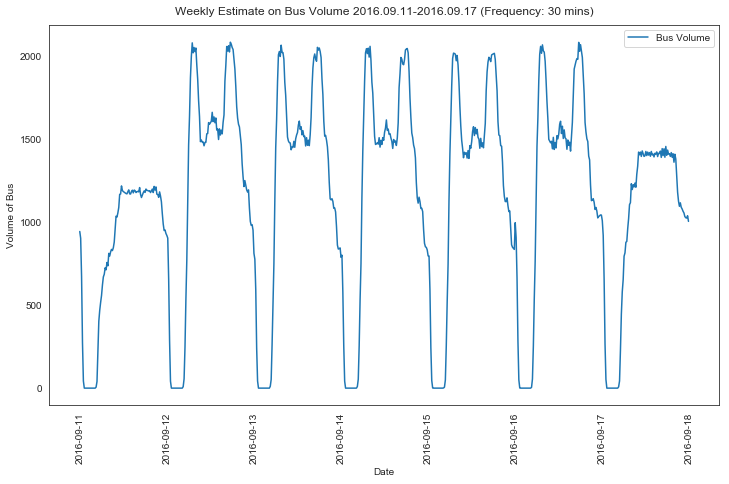

In [24]:
n = len(dailydata_Bus)
#ticks_to_use = Bus_delay.time_stamp[::1] # Every 5 hr 
#labels = [ i for i in ticks_to_use ]
plt.rcParams['figure.figsize'] = [12, 7]
window = 50
rolling_mean = dailydata_Bus['total_volume'].rolling(window = window, center=False).mean()
plt.plot(dailydata_Bus['timestamp'], dailydata_Bus['total_volume'], label="Bus Volume")
plt.xticks(rotation=90)
plt.ylabel("Volume of Bus")
plt.xlabel("Date")
plt.title("Weekly Estimate on Bus Volume 2016.09.11-2016.09.17 (Frequency: 30 mins)")
plt.legend(loc="upper right")

In [25]:
dailydata_Bus_1 = dailydata_Bus.iloc[0:101]

In [26]:
dailydata_Bus_1

,arrrival_delay_seconds,departure_delay_seconds,total_volume,timestamp,departure_day
datetime,,,,,
2016-09-11 00:00:00,201.666667,4660.316667,945,2016-09-11 00:00:00,Sunday
2016-09-11 00:15:00,-1088.325000,435.841667,904,2016-09-11 00:15:00,Sunday
2016-09-11 00:30:00,-5331.375000,-6876.050000,673,2016-09-11 00:30:00,Sunday
2016-09-11 00:45:00,-1588.250000,-1002.166667,275,2016-09-11 00:45:00,Sunday
2016-09-11 01:00:00,-643.500000,888.500000,43,2016-09-11 01:00:00,Sunday
...,...,...,...,...,...
2016-09-12 00:00:00,5643.591667,9330.233333,921,2016-09-12 00:00:00,Monday
2016-09-12 00:15:00,3143.016667,4079.516667,905,2016-09-12 00:15:00,Monday
2016-09-12 00:30:00,-2217.650000,-3124.391667,658,2016-09-12 00:30:00,Monday


In [71]:
dailydata_Bus1d = dailydata_Bus.resample('H').sum()
dailydata_Bus1d['timestamp'] = dailydata_Bus1d.index 
dailydata_Bus1d['departure_day'] = [calendar.day_name[x.weekday()] for x in dailydata_Bus1d['timestamp']]

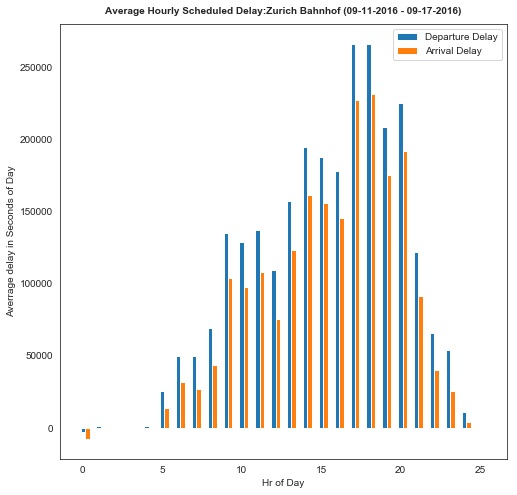

In [67]:


fig, ax1 = plt.subplots(1,1, figsize=(8, 8))# create a subplot axis
bar_width = 0.28 # assign a width for each barplot 


ax1.bar([x for x in range(dailydata_Bus_1d.shape[0])],[y for y in dailydata_Bus_1d['departure_delay_seconds']],bar_width,label='Departure Delay',align='center')
    
ax1.bar([x+bar_width for x in range(dailydata_Bus_1d.shape[0])],[y for y in dailydata_Bus_1d['arrrival_delay_seconds']],bar_width,label='Arrival Delay',align='center')
#set the vertical axis tick labels using the list created above
#ax1.set_yticklabels(ylab)
plt.ylabel("Averrage delay in Seconds of Day")
plt.xlabel("Hr of Day")
plt.title(r'Average Hourly Scheduled Delay:Zurich Bahnhof (09-11-2016 - 09-17-2016)',fontsize=10,fontweight='bold')
plt.legend(loc="upper right")
#show the plot
#fig.suptitle(r'Average Hourly Scheduled Delay:Zurich Bahnhof (09-11-2016 - 09-17-2016)',fontsize=10,fontweight='bold')
plt.show()



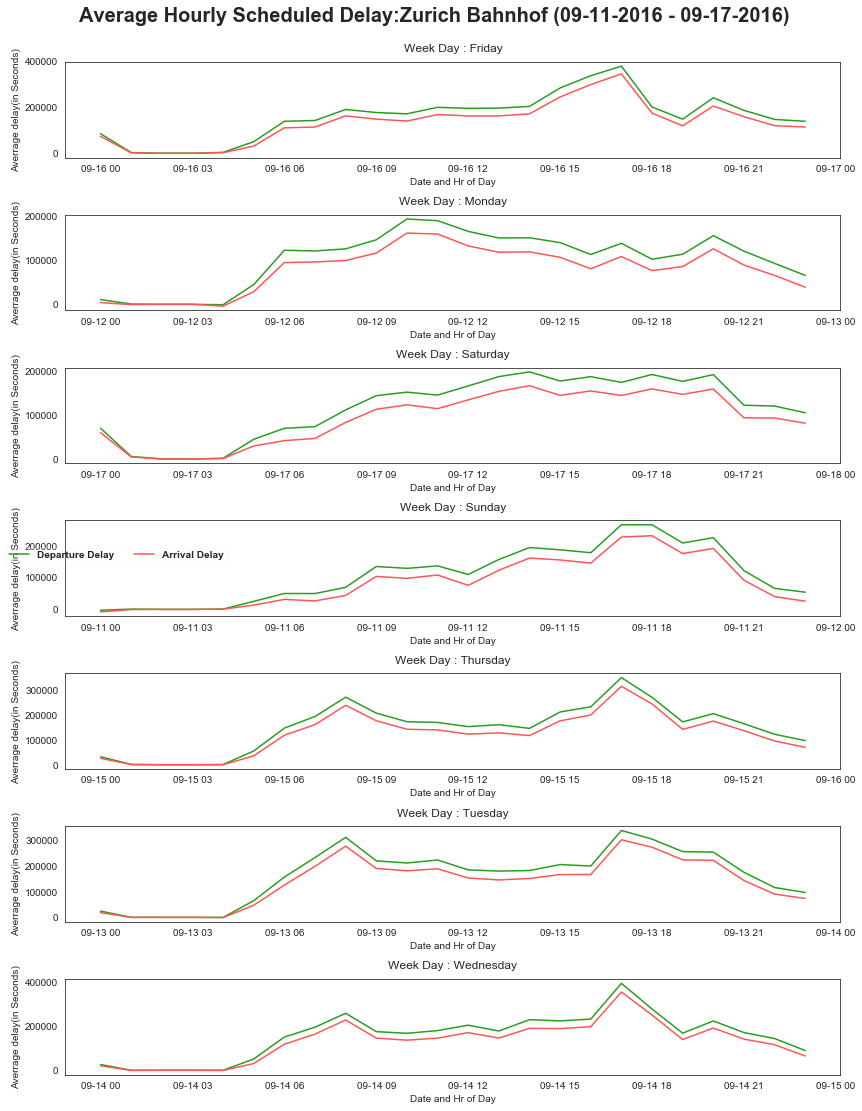

In [80]:
le = preprocessing.LabelEncoder()
week_idx = le.fit_transform(dailydata_Bus['departure_day'])
week = le.classes_

fig, axs = plt.subplots(7,1, figsize=(12, 15))
axs = axs.ravel()


for i, j, p in zip([0,1,2,3,4,5,6], [0,1,2,3,4,5,6], week):
    
    axs[j].set_ylabel("Averrage delay(in Seconds)")
    axs[j].set_xlabel('Date and Hr of Day')
    
    axs[j].set_title('Week Day : %s' % p)
    axs[j].plot(dailydata_Bus1d[dailydata_Bus1d['departure_day']==p]['timestamp'],\
                [y for y in dailydata_Bus1d[dailydata_Bus1d['departure_day']==p]['departure_delay_seconds']], color="#299C21", label='Departure Delay')
    axs[j].plot(dailydata_Bus1d[dailydata_Bus1d['departure_day']==p]['timestamp'],\
                [y for y in dailydata_Bus1d[dailydata_Bus1d['departure_day']==p]['arrrival_delay_seconds']], color="#FF5555", label='Arrival Delay')

    



handles, labels = axs[6].get_legend_handles_labels()
legend_properties = {'weight':'bold'}
fig.legend(handles, labels, loc='center left',ncol=2,fancybox=True, framealpha=0.1,prop=legend_properties)
fig.suptitle(r'Average Hourly Scheduled Delay:Zurich Bahnhof (09-11-2016 - 09-17-2016)',y=1.025,fontsize=20,fontweight='bold')

plt.tight_layout(True);

In [53]:
[y for y in dailydata_Bus_1d['departure_delay_seconds']]

[2626517.119047618, 11299.608333333335]

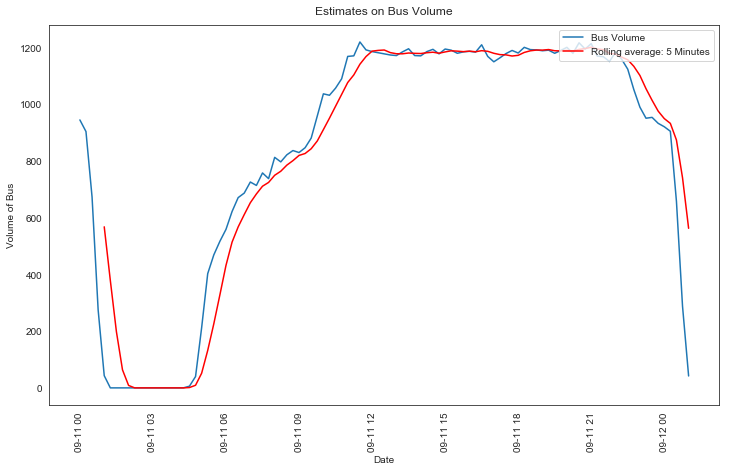

In [27]:
#ticks_to_use = Bus_delay.time_stamp[::1] # Every 5 hr 
#labels = [ i for i in ticks_to_use ]
plt.rcParams['figure.figsize'] = [12, 7]
window = 5
rolling_mean = dailydata_Bus_1['total_volume'].rolling(window = window, center=False).mean()
plt.plot(dailydata_Bus_1['timestamp'], dailydata_Bus_1['total_volume'], label="Bus Volume")
plt.plot(rolling_mean, color='r', label="Rolling average: %i Minutes" % window)
plt.xticks(rotation=90)
plt.ylabel("Volume of Bus")
plt.xlabel("Date")
plt.title("Estimates on Bus Volume")
plt.legend(loc="upper right")

In [16]:
import pymc3 as pm

m = pm.Model()
n = len(dailydata_Bus_1)

with m:
    
    alpha = 1.0 / dailydata_Bus_1['total_volume'].mean()
    
    #prior distributions
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)



    
    tau_1 = pm.DiscreteUniform("tau_1", lower=n*0.2, upper=n*0.5)
    tau_2 = pm.DiscreteUniform("tau_2", lower=n*0.5, upper=n)
  






    
    idx = np.arange(n) # Index
    
    lambda_ = pm.math.switch(tau_2 >= idx,\
                pm.math.switch(tau_1 >= idx,lambda_1, lambda_2),lambda_3)
              
    #lambda_  = pm.math.switch(tau_1 >= idx,lambda_1, lambda_2)
    
    prob = pm.Deterministic('lambda', lambda_)

    # Define the likelihood function.
    
    y_obs = pm.Poisson("obs", prob, observed=dailydata_Bus_1['total_volume'])
    
    #advi = pm.ADVI()
    #trace_a = advi.fit(10000)
    #trace = trace_a.sample(10000)
    
    step = pm.NUTS()
    trace = pm.sample(1000,step, model= m)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_3, lambda_2, lambda_1]
>CompoundStep
>>Metropolis: [tau_2]
>>Metropolis: [tau_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [02:06<00:00, 23.68draws/s]
The acceptance probability does not match the target. It is 0.8814022126811667, but should be close to 0.8. Try to increase the number of tuning steps.


In [17]:
with m:
    ppc = pm.sample_ppc(trace, samples=1000, progressbar=True)

100%|██████████| 1000/1000 [00:01<00:00, 576.77it/s]


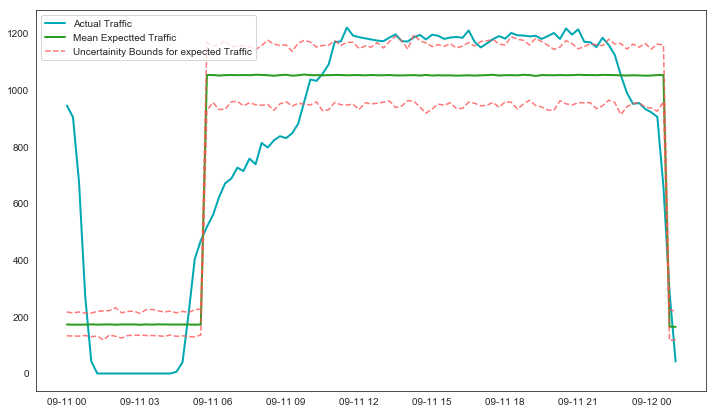

In [18]:
ax = plt.subplot()

ax.plot(dailydata_Bus_1['timestamp'], dailydata_Bus_1['total_volume'], color="#00A8B3",linewidth=2, label='Actual Traffic') 

ax.plot(dailydata_Bus_1['timestamp'], ppc['obs'].mean(axis=0), color="#299C21",linewidth=2.0,label='Mean Expectted Traffic')

ax.plot(dailydata_Bus_1['timestamp'],ppc['obs'].max(axis=0),'--',color = '#FF5555',alpha=0.8,label='Uncertainity Bounds for expected Traffic')

ax.plot(dailydata_Bus_1['timestamp'],ppc['obs'].min(axis=0),'--',color = '#FF5555',alpha=0.8)

plt.legend(loc="upper left")

In [85]:
from sklearn import preprocessing
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
week_idx = le.fit_transform(dailydata_Bus['departure_day'])
week = le.classes_
n_week = len(week)

for p in week:
    m = pm.Model()
    

    with m:
    
        data = dailydata_Bus[dailydata_Bus['departure_day']==p]['total_volume'].values
        
        alpha = 1.0 / data.mean()
        n = len(data)
    
        lambda_1 = pm.Exponential("lambda_1", alpha)
        lambda_2 = pm.Exponential("lambda_2", alpha)
        lambda_3 = pm.Exponential("lambda_3", alpha)



    
        tau_1 = pm.DiscreteUniform("tau_1", lower=n*0.2, upper=n*0.5)
        tau_2 = pm.DiscreteUniform("tau_2", lower=n*0.5, upper=n)
        idx = np.arange(n) # Index
    
        lambda_ = pm.math.switch(tau_2 >= idx,\
                pm.math.switch(tau_1 >= idx,lambda_1, lambda_2),lambda_3)
              
        #lambda_  = pm.math.switch(tau_1 >= idx,lambda_1, lambda_2)
    
        prob = pm.Deterministic('lambda', lambda_)
        
        

        # Define the likelihood function.
        y_obs = pm.Poisson("obs", prob, observed=data)

        
        step = pm.NUTS()
        trace = pm.sample(1000,step, model= m)
        
        
        indiv_traces[p] = pm.sample_ppc(trace, samples=1000, progressbar=True)
        

    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_3, lambda_2, lambda_1]
>CompoundStep
>>Metropolis: [tau_2]
>>Metropolis: [tau_1]
100%|██████████| 1000/1000 [00:01<00:00, 664.03it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_3, lambda_2, lambda_1]
>CompoundStep
>>Metropolis: [tau_2]
>>Metropolis: [tau_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [02:00<00:00, 24.84draws/s]
The acceptance probability does not match the target. It is 0.8801204687542529, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 1000/1000 [00:01<00:00, 663.54it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_3, lambda_2, lambda_1]
>CompoundStep
>>Metropolis: [tau_2]
>>Metropolis: [tau_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [01:40<00:00, 29.98draws/s]
The acceptance probability does not match the target. It is 0.8833477262580782, but should be close to 0.8. 

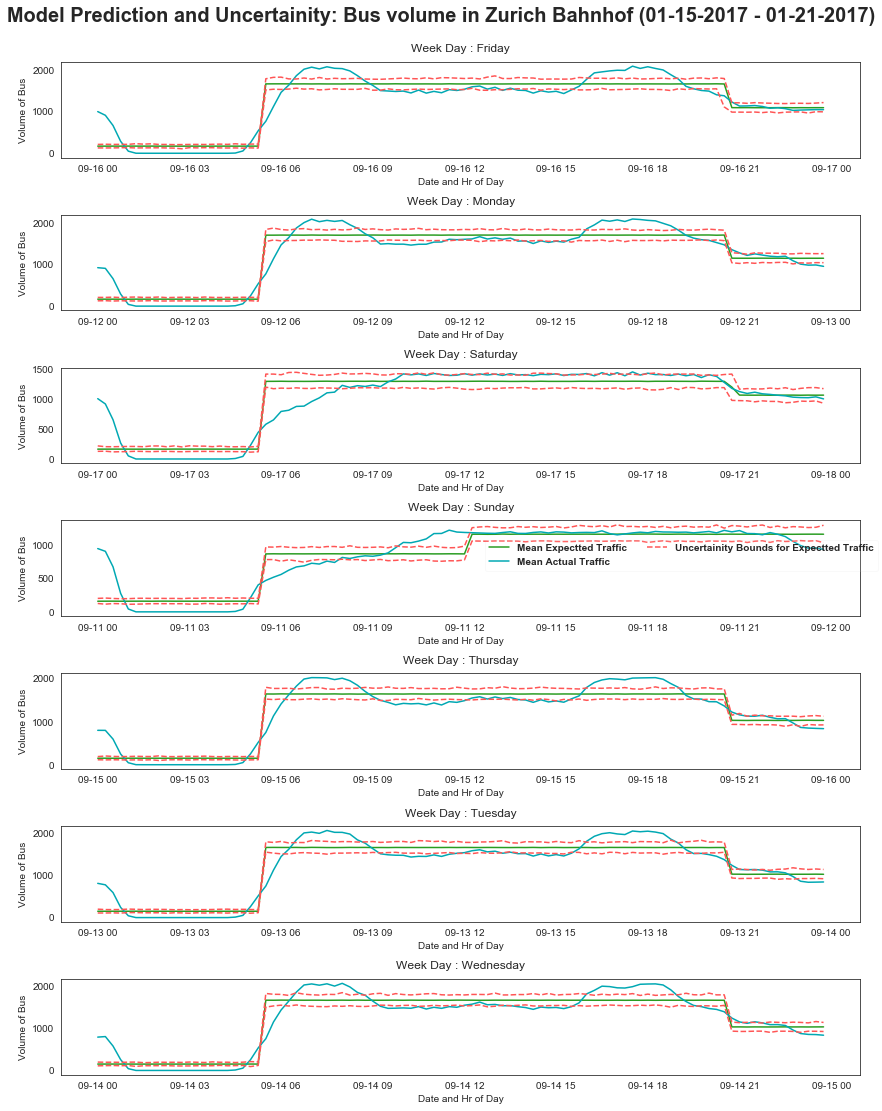

In [86]:
fig, axs = plt.subplots(7,1, figsize=(12, 15))
axs = axs.ravel()


for i, j, p in zip([0,1,2,3,4,5,6], [0,1,2,3,4,5,6], week):
    
    axs[j].set_ylabel("Volume of Bus")
    axs[j].set_xlabel('Date and Hr of Day')
    
    axs[j].set_title('Week Day : %s' % p)
    
    axs[j].plot(dailydata_Bus[dailydata_Bus['departure_day']==p]['timestamp'],\
                indiv_traces[p]['obs'].mean(axis=0), color="#299C21", label='Mean Expectted Traffic')
    
    axs[j].plot(dailydata_Bus[dailydata_Bus['departure_day']==p]['timestamp'],dailydata_Bus[dailydata_Bus['departure_day']==p]['total_volume'],\
                color="#00A8B3", label='Mean Actual Traffic')
    
    axs[j].plot(dailydata_Bus[dailydata_Bus['departure_day']==p]['timestamp'],\
                indiv_traces[p]['obs'].max(axis=0),'--', color="#FF5555", label='Uncertainity Bounds for Expectted Traffic')
    
    axs[j].plot(dailydata_Bus[dailydata_Bus['departure_day']==p]['timestamp'],\
                indiv_traces[p]['obs'].min(axis=0),'--', color="#FF5555")
    


handles, labels = axs[6].get_legend_handles_labels()
legend_properties = {'weight':'bold'}
fig.legend(handles, labels, loc='right',ncol=2,fancybox=True, framealpha=0.1,prop=legend_properties)
fig.suptitle(r'Model Prediction and Uncertainity: Bus volume in Zurich Bahnhof (01-15-2017 - 01-21-2017)',y=1.025,fontsize=20,fontweight='bold')

plt.tight_layout(True);

In [150]:
dailydata1 = pd.read_csv('fahrzeitensollist2017011520170121.csv')

In [151]:
dailydata_Bus1 = dailydata1[dailydata1['linie'] >17]
dailydata_Bus1 = d_t_split(dailydata_Bus1)
dailydata_Bus1 = dailydata_Bus1.resample('15T').count()
dailydata_Bus1['timestamp'] = dailydata_Bus1.index


In [24]:
week_idx1 = le.fit_transform(dailydata_Bus1['departure_day'])
week1 = le.classes_
n_week1 = len(week1)

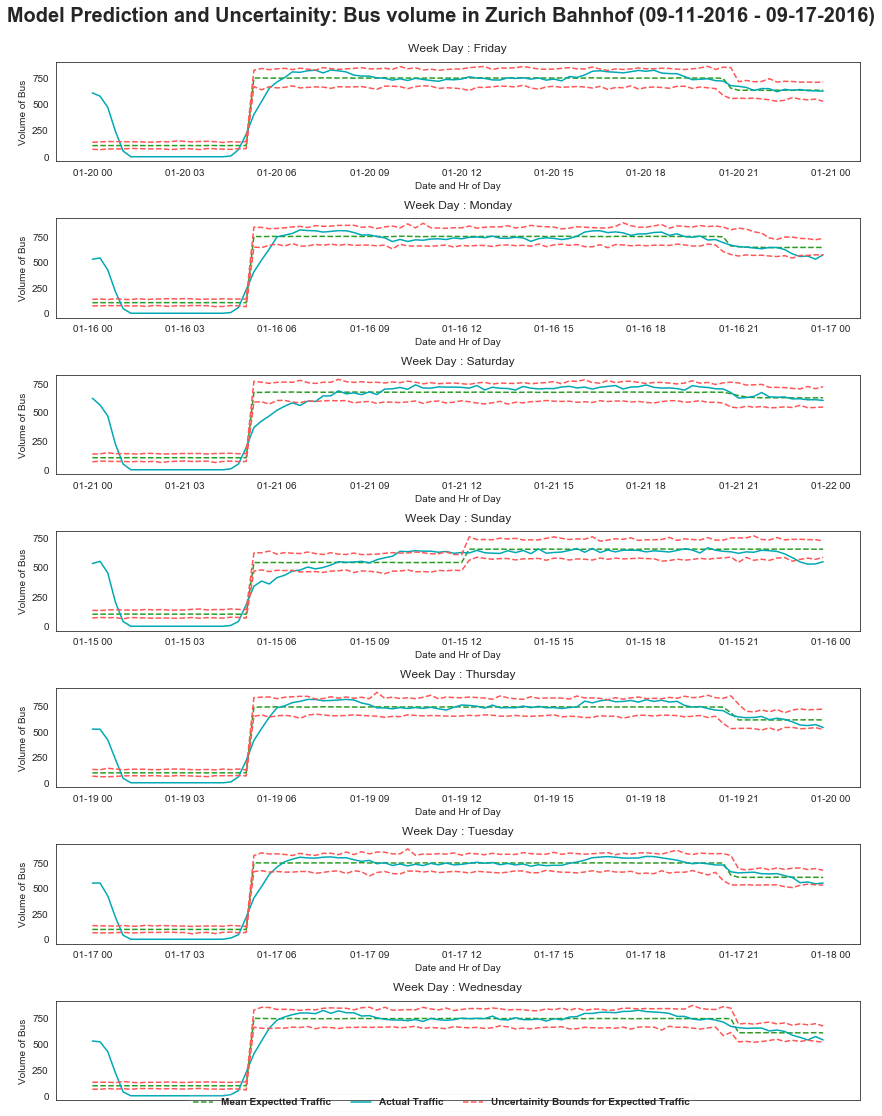

In [42]:
fig, axs = plt.subplots(7,1, figsize=(12, 15))
axs = axs.ravel()


for i, j, p in zip([0,1,2,3,4,5,6], [0,1,2,3,4,5,6], week):
    
    axs[j].set_ylabel("Volume of Bus")
    axs[j].set_xlabel('Date and Hr of Day')
    
    axs[j].set_title('Week Day : %s' % p)
    
    axs[j].plot(dailydata_Bus1[dailydata_Bus1['departure_day']==p]['timestamp'],\
                indiv_traces[p]['obs'].mean(axis=0),'--', color="#299C21", label='Mean Expectted Traffic')
    
    axs[j].plot(dailydata_Bus1[dailydata_Bus1['departure_day']==p]['timestamp'],dailydata_Bus1[dailydata_Bus1['departure_day']==p]['total_volume'],\
                color="#00A8B3", label='Actual Traffic')
    
    axs[j].plot(dailydata_Bus1[dailydata_Bus1['departure_day']==p]['timestamp'],\
                indiv_traces[p]['obs'].max(axis=0),'--', color="#FF5555", label='Uncertainity Bounds for Expectted Traffic')
    
    axs[j].plot(dailydata_Bus1[dailydata_Bus1['departure_day']==p]['timestamp'],\
                indiv_traces[p]['obs'].min(axis=0),'--', color="#FF5555")
    


handles, labels = axs[6].get_legend_handles_labels()
legend_properties = {'weight':'bold'}
fig.legend(handles, labels, loc='lower center',ncol = 3,fancybox=True, framealpha=0.1,prop=legend_properties)
fig.suptitle(r'Model Prediction and Uncertainity: Bus volume in Zurich Bahnhof (09-11-2017 - 09-17-2017)',y=1.025,fontsize=20,fontweight='bold')
axs[6].axes.xaxis.set_visible(False)
plt.tight_layout(True);

In [94]:
dailydata_Bus_arima = dailydata_Bus[['total_volume']]

In [95]:
dailydata_Bus_arima

,total_volume
datetime,
2016-09-11 00:00:00,945
2016-09-11 00:15:00,904
2016-09-11 00:30:00,673
2016-09-11 00:45:00,275
2016-09-11 01:00:00,43
...,...
2016-09-17 22:45:00,1035
2016-09-17 23:00:00,1028
2016-09-17 23:15:00,1026


In [101]:
from statsmodels.tsa.stattools import adfuller
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['total_volume'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [112]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

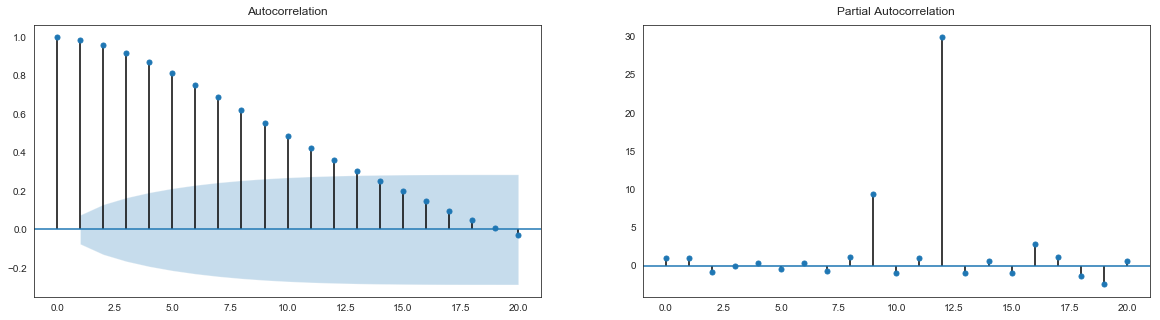

In [114]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(dailydata_Bus_arima.values, lags=20, alpha=0.05, ax=axes[0])
plot_pacf(dailydata_Bus_arima.values, lags=20, alpha=0.05, ax=axes[1])
plt.show()

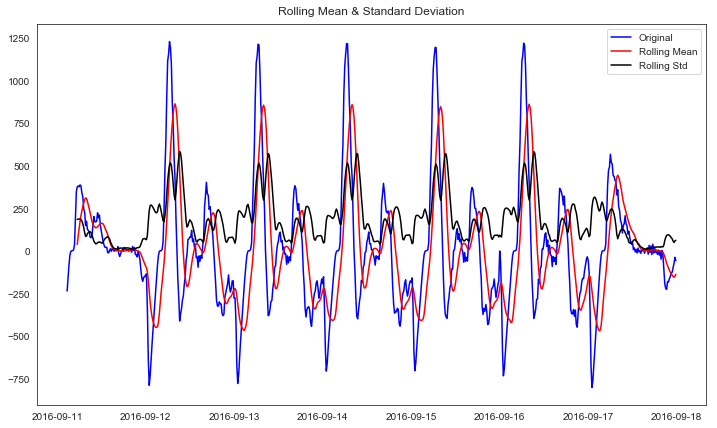

ADF Statistic: -5.532437908861344
p-value: 1.7750756230902862e-06
Critical Values:
	1%: -3.440560883168159
	5%: -2.8660454146233434
	10%: -2.569169329058723


In [102]:
rolling_mean = dailydata_Bus_arima.rolling(window=12).mean()
df_log_minus_mean = dailydata_Bus_arima - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

In [108]:
import xlrd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from itertools import product

from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime


In [142]:
from sklearn.linear_model import LinearRegression

def fit_ar_model(ts, orders):
    
    X=np.array([ ts.values[(i-orders)].squeeze() if i >= np.max(orders) else np.array(len(orders) * [np.nan]) for i in range(len(ts))])
    
    mask = ~np.isnan(X[:,:1]).squeeze()
    
    Y= ts.values
    
    lin_reg=LinearRegression()
    
    lin_reg.fit(X[mask],Y[mask])
    
    print(lin_reg.coef_, lin_reg.intercept_)

    print('Score factor: %.2f' % lin_reg.score(X[mask],Y[mask]))
    
    return lin_reg.coef_, lin_reg.intercept_
    
def predict_ar_model(ts, orders, coef, intercept):
    return np.array([np.sum(np.dot(coef, ts.values[(i-orders)].squeeze())) + intercept  if i >= np.max(orders) else np.nan for i in range(len(ts))])

[[ 1.07719417 -0.15960698  0.04408023]] [44.96270448]
Score factor: 0.98


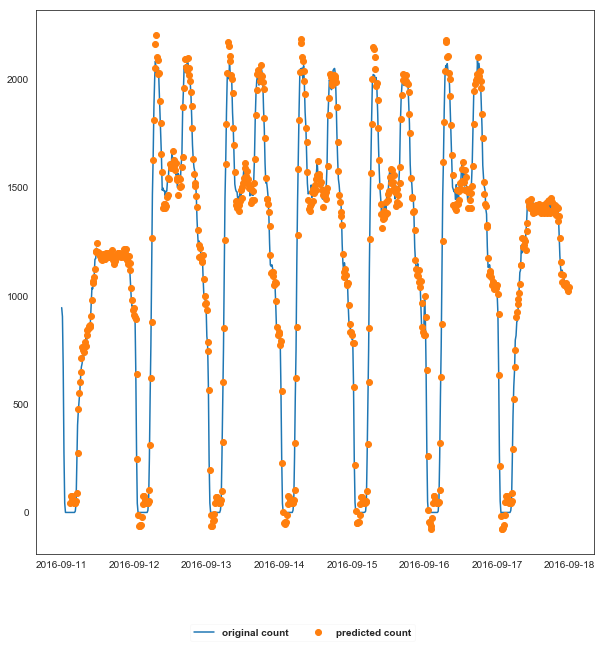

In [163]:
orders=np.array([1,8,11])
coef, intercept = fit_ar_model(dailydata_Bus_arima,orders)
pred=pd.DataFrame(index=dailydata_Bus_arima.index, data=predict_ar_model(dailydata_Bus_arima, orders, coef, intercept))

fig, axs = plt.subplots(1,1, figsize=(10, 10))
axs.plot(dailydata_Bus_arima,label = 'original count')
axs.plot(pred,'o',label= 'predicted count')
handles, labels = axs.get_legend_handles_labels()
legend_properties = {'weight':'bold'}
fig.legend(handles, labels, loc='lower center',ncol = 3,fancybox=True, framealpha=0.1,prop=legend_properties)
plt.show()

In [ ]:
Our final plan was to combine the high frequency interval predictions on an hourly basis, and use the combined prediction to ultimately trigger the alerts. Yet, our models were ultimately too inaccurate to achieve any meaningful results even when combined in that way. Overall, the different measurement frequencies, seeming lack of relevant features and generally poor data quality and documentation severely limited us in our attempts. In order to build an accurate and helpful model, the dataset has to be severely improved in terms of quality, documentation and extensiveness in terms of features and observations. It is also important to note that while the dataset contained more than 700000 observations, the actual amount of observations for Silica Concentrate was only about 4000, with only 290 distinct values after removing interpolated hours. Thus, the size of the dataset might seem large, but seems to contain very little relevant information. In terms of modelling approaches, we also discussed other approaches such as more time series related methods or using hourly patterns as features, yet the quality of existing data and lack of
